In [1]:
include("DG_Functions.jl")
include("Specific_DG_Functions.jl")
include("DG_Methods.jl")
include("Differentiation.jl")

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


grad (generic function with 1 method)

In [2]:
function dLegendreP(k,x)
    k<=K_max || throw(DomainError())
    return array2poly(symbolic_diff(Leg_coeffs[k+1]),x)
end

function dLegendreP(k)
    k<=K_max || throw(DomainError())
    return array2poly(symbolic_diff(Leg_coeffs[k+1]))
end

function dh(k,f_number,x)
    f_number<=k || throw(DomainError())
    return array2poly(symbolic_diff((DG_coeffs[k])[f_number]),x)
end

function dh(k,f_number)
    f_number<=k || throw(DomainError())
    return array2poly(symbolic_diff((DG_coeffs[k])[f_number]))
end

function dv(k::Int, level::Int, place::Int, f_number::Int, x::Real)
	if level==0 # At the base level, we are not discontinuous, and we simply
                # use Legendre polynomials up to degree k-1 as a basis
        return 2*dLegendreP(f_number-1,2*x-1)*sqrt(2.0)
	else
        return (1<<(level))*dh(k, f_number, (1<<level)*x - (2*place-1)) * (2.0)^(level/2)
        # Otherwise we use an appropriately shifted, scaled, and normalized
		# DG function
	end
end

function dv(k::Int, level::Int, place::Int, f_number::Int)
    return (xs::Real -> dv(k,level,place,f_number,xs))
end

function dV{D,T<:Real}(i::Int, k::Int, level::NTuple{D,Int}, 
    place::CartesianIndex{D}, f_number::CartesianIndex{D}, xs::AbstractArray{T})

    ans = one(eltype(xs))
    for j = 1:D
        if j == i
            ans *= dv(k, level[j], place[j], f_number[j], xs[j])
        else
            ans *= v(k, level[j], place[j], f_number[j], xs[j])
        end
    end
    return ans
end

function dV{D}(i, k, level::NTuple{D,Int}, 
                place::CartesianIndex{D}, f_number::CartesianIndex{D})
    return (xs::AbstractArray{Real} -> dV(i, k, level, place, f_number, xs))
end

function inner_product1D(f::Function, g::Function, lvl::Int, place::Int)
    xmin = (place-1)/(1<<(pos(lvl-1)))
	xmax = (place)/(1<<(pos(lvl-1)))
	h = (x-> f(x)*g(x))
    (val, err) = hquadrature(h, xmin, xmax; reltol=1e-8, abstol=1e-8, maxevals=0)
	return val 
end
#don't need to do anything numerically here, I don't think

function symbolic_diff{T<:Real}(v::Array{T})
	n=length(v)
    k=div(n,2)
	ans = zeros(T,n)
	for i in 1:n
		if i<k
			ans[i] = i*v[i+1]
		elseif i > k && i<2k
			ans[i] = (i-k) * v[i+1]
		else
			ans[i]=0
		end
	end
	return ans
end
#working

function legendreDlegendre(f_number1::Int, f_number2::Int)
	return inner_product(Leg_coeffs[f_number1],symbolic_diff(Leg_coeffs[f_number2]))
end 


function hDh(k::Int, f_number1::Int, f_number2::Int)
	return inner_product(DG_coeffs[k][f_number1], symbolic_diff(DG_coeffs[k][f_number2]))
end

function vDv(k::Int, lvl1::Int, place1::Int, f_number1::Int, lvl2::Int, place2::Int, f_number2::Int)
	if lvl1 == lvl2
		if lvl1 == 0
			return 2*legendreDlegendre(f_number1, f_number2)
		end
		if place1 == place2
			return hDh(k, f_number1, f_number2)*(1<<pos(lvl1))
		end
		return 0.0
	end
	if lvl1 < lvl2
		if lvl1 == 0
            return inner_product1D(v(k,0,1,f_number1), dv(k,lvl2,place2,f_number2), lvl2, place2)
		end
		if (1<<(lvl2-lvl1))*place1 >= place2 && (1<<(lvl2-lvl1))*(place1-1) < place2
            #@show (lvl1, place1, lvl2, place2)
            return inner_product1D(v(k,lvl1,place1,f_number1), dv(k,lvl2,place2,f_number2), lvl2, place2)
		end
		return 0.0
    end
	return 0.0

end

function D_reconstruct_DG{D,T<:Real}(i::Int, k::Int,
                                coefficients::Dict{CartesianIndex{D}, Array{Array{Float64},D}}, x::Array{T})
    value = 0.0
    f_numbers= ntuple(i-> k ,D)
    for key in keys(coefficients)	#For every level that has coefficients
        level = ntuple(i->key[i]-1,D)	# Get the actual level corresponding to that CartesianIndex
        place = CartesianIndex{D}(ntuple(i->hat_index(x[i],level[i]),D))
        # Get the relevant place for our position x
		for f_number in CartesianRange(f_numbers)
            value += (coefficients[key])[CartesianIndex{D}(place)][f_number]*dV(i,k,level,place,f_number,x)
		end 
		#get the appropriate coefficient and evaluate the appropriate ϕ at x
    end
    return value	#return the sum of all the relevant hat functions at that place x
end



D_reconstruct_DG (generic function with 1 method)

In [3]:
#hier_coefficients_DG(3, dv(k,level,place,f_number), (level+1,))
hier_coefficients_DG(3, x->dv(3,3,3,3,x[1]), (3+1,))


function diff_basis_DG(k::Int, level::Int, place::Int, f_number::Int)
    dcoeffs = Array(Float64, (level+1,k))
    p = place
    for l in level:-1:0
        for f_n in 1:k
            dcoeffs[l+1,f_n]=vDv(k, l, p, f_n, level, place, f_number)
        end
        p = Int(ceil(p/2))
    end
    return dcoeffs
end

precomputed_diffs = Dict{NTuple{4,Int},Array{Float64,2}}()

for level in 0:7
    for place in 1:(1<<pos(level-1)) 
        for f_number in 1:3
            precomputed_diffs[(3,level,place,f_number)] = diff_basis_DG(3,level,place,f_number)
        end
    end
end

function dchange{D,T<:Real}(k::Int,i::Int,dcoeffs::Dict{CartesianIndex{D}, Array{Array{Float64},D}},c::T,
    lvl::NTuple{D,Int}, place::CartesianIndex{D}, f_number::CartesianIndex{D})
    p = place[i]
    for l in lvl[i]:-1:0
        lvl1= ntuple(j-> j==i?l+1:(lvl[i]+1) ,D)
        place1=ntuple(j-> j==i?p:place[i] ,D)
        for f_n in 1:k
            f_number1=ntuple(j-> j==i?f_n:f_number[i] ,D)
            dcoeffs[CartesianIndex{D}(lvl1)][CartesianIndex{D}(place1)][CartesianIndex{D}(f_number1)] += c*precomputed_diffs[(k,lvl[i],place[i],f_number[i])][l+1,f_n]
        end
        p = Int(ceil(p/2))
    end
end


function diff_coefficients_DG{D}(i::Int, k::Int,
                        coeffs::Dict{CartesianIndex{D}, Array{Array{Float64},D}})
    
    dcoeffs=deepcopy(coeffs)
    f_numbers= ntuple(i-> k, D)
    
    for key in keys(coeffs)
        ks = ntuple(i -> 1<<pos(key[i]-2), D) 
        for place in CartesianRange(ks)
            for f_number in CartesianRange(f_numbers)
                dcoeffs[key][place][f_number]=0
            end
        end
    end
    
    for key in keys(coeffs)
        level = ntuple(i-> key[i]-1,D)
        ks = ntuple(i -> 1<<pos(level[i]-1), D) 
        for place in CartesianRange(ks)
            for f_number in CartesianRange(f_numbers)
                c=coeffs[key][place][f_number]
                dchange(k,i,dcoeffs,c,level,place,f_number)
            end
        end
    end
    return dcoeffs
end
    

diff_coefficients_DG (generic function with 1 method)

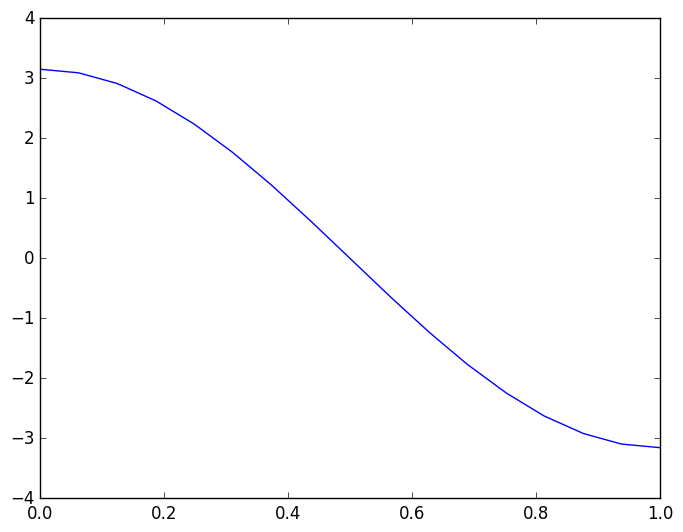

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x317192310>

In [4]:
#coeffs1=hier_coefficients_DG(3,(x->v(3,0,1,2,x[1])),(4,))
coeffs1=hier_coefficients_DG(3,(x->sin(pi*x[1])),(5,))
coeffsd=diff_coefficients_DG(1,3,coeffs1)
plotfunc1D(x->reconstruct_DG(3,coeffsd,[x[1]]))#-pi*cos(pi*x[1]))

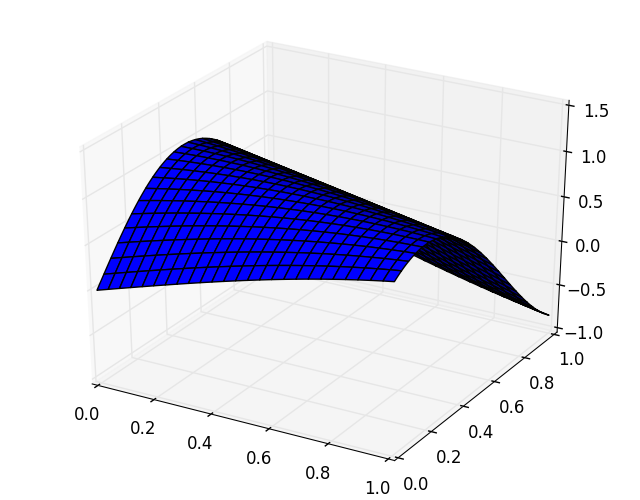

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x316d7c890>

In [10]:
coeffs2=hier_coefficients_DG(3,(x->sin(pi*x[1]+x[2])),(5,5))
plotfunc2D(x->reconstruct_DG(3,coeffs2,[x[1],x[2]]))

In [8]:
coeffsd2=diff_coefficients_DG(1,3,coeffs2)
coeffs2[CartesianIndex{2}((3,3))]
coeffsd2[CartesianIndex{2}((3,3))]

2x2 Array{Array{Float64,N},2}:
 3x3 Array{Float64,2}:
  0.0          -0.0192581    0.0       
 -6.61318e-19   0.0          0.00048915
  0.0           5.92523e-17  0.0         …  3x3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0                                                                        
 3x3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0                                                                                3x3 Array{Float64,2}:
  0.0           0.000205061  0.0      
 -6.21073e-17   0.0          0.0459382
  0.0          -6.30918e-19  0.0      

In [126]:
#precomputed_diffs[(3,0,1,3)]
coeffsd[CartesianIndex{1}((1,))]

1-element Array{Array{Float64,N},1}:
 [-7.440665799197085e-16,3.872983346207419,2.6086785256087082e-15]

In [66]:
@show precomputed_diffs[(3,3,1,3)]
@show precomputed_diffs[(3,3,2,3)]
@show precomputed_diffs[(3,3,3,3)]
@show precomputed_diffs[(3,4,1,3)]

precomputed_diffs[(3,3,1,3)] = [7.3086322848894e-16 -1.5543122344752192e-15 1.8750000000000018
 -8.881784197001252e-15 -7.261843774138928 -7.500000000000021
 -5.5067062021407764e-14 -41.0791918128876 -42.42640687119299
 0.0 7.745966692414754 0.0]
precomputed_diffs[(3,3,2,3)] = [6.725016051301372e-16 -2.220446049250313e-16 1.8750000000000018
 -9.769962616701378e-15 -7.261843774138933 -7.500000000000024
 5.5067062021407764e-14 -41.0791918128876 42.426406871192995
 0.0 7.745966692414754 0.0]
precomputed_diffs[(3,3,3,3)] = [-5.134729513976429e-17 2.220446049250313e-16 1.8750000000000013
 9.325873406851315e-15 -7.2618437741389315 7.500000000000025
 -5.3290705182007514e-14 -41.079191812887586 -42.42640687119298
 0.0 7.745966692414754 0.0]
precomputed_diffs[(3,4,1,3)] = [1.3484309855560356e-15 -1.7763568394002505e-15 0.6629126073623883
 -5.773159728050814e-15 -2.567449488305476 -2.651650429449554
 -1.687538997430238e-14 -14.52368754827786 -15.000000000000043
 -1.1013412404281553e-13 -82.15838

5x3 Array{Float64,2}:
  1.34843e-15   -1.77636e-15    0.662913
 -5.77316e-15   -2.56745       -2.65165 
 -1.68754e-14  -14.5237       -15.0     
 -1.10134e-13  -82.1584       -84.8528  
  0.0           15.4919         0.0     

In [46]:
print(diff_coefficients_DG(3,3,3,3))
println("\n")
@show hier_coefficients_DG(3, x->dv(3,3,3,3,x[1]), (3+1,))

[-5.134729513976429e-17 2.220446049250313e-16 1.8750000000000013
 9.325873406851315e-15 -7.2618437741389315 7.500000000000025
 -5.3290705182007514e-14 -41.079191812887586 -42.42640687119298
 0.0 7.745966692414754 0.0]

hier_coefficients_DG(3,(x->begin  # In[46], line 3:
            dv(3,3,3,3,x[1])
        end),(3 + 1,)) = Dict(CartesianIndex{1}((3,))=>Array{Float64,N}[[0.0,0.0,0.0],[-5.3290705182007514e-14,-41.079191812887586,-42.42640687119298]],CartesianIndex{1}((2,))=>Array{Float64,N}[[9.325873406851315e-15,-7.2618437741389315,7.500000000000025]],CartesianIndex{1}((1,))=>Array{Float64,N}[[-5.134729513976429e-17,2.220446049250313e-16,1.8750000000000013]],CartesianIndex{1}((4,))=>Array{Float64,N}[[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,15.491933384829702,0.0],[0.0,0.0,0.0]])


Dict{CartesianIndex{1},Array{Array{Float64,N},1}} with 4 entries:
  CartesianIndex{1}((3,)) => Array{Float64,N}[[0.0,0.0,0.0],[-5.329070518200751…
  CartesianIndex{1}((2,)) => Array{Float64,N}[[9.325873406851315e-15,-7.2618437…
  CartesianIndex{1}((1,)) => Array{Float64,N}[[-5.134729513976429e-17,2.2204460…
  CartesianIndex{1}((4,)) => Array{Float64,N}[[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,…

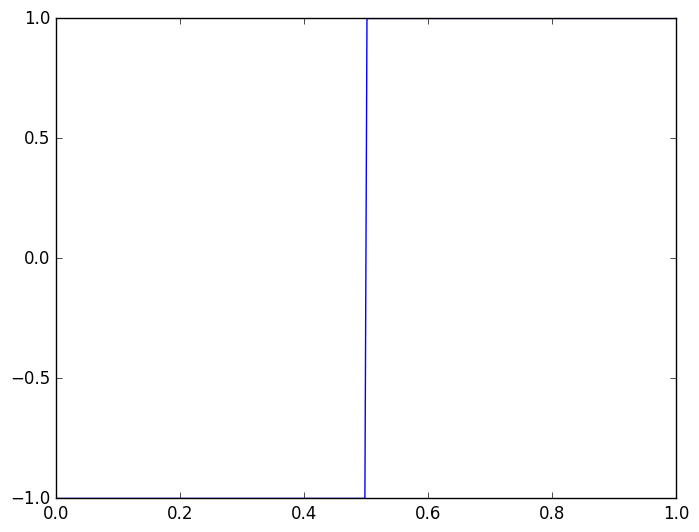

[vDv(3,1,1,i,1,1,3) for i = 1:3] = [0.0,3.872983346207377,0.0]
[vDv(3,0,1,i,1,1,3) for i = 1:3] = [4.903568041842771e-16,-1.4369046910717228e-15,15.000000000000025]


Dict{CartesianIndex{1},Array{Array{Float64,N},1}} with 3 entries:
  CartesianIndex{1}((3,)) => Array{Float64,N}[[0.0,3.3306690738754696e-16,-1.80…
  CartesianIndex{1}((2,)) => Array{Float64,N}[[0.4999999999999999,-1.6653345369…
  CartesianIndex{1}((1,)) => Array{Float64,N}[[0.0,0.8660254037844387,3.1225022…

In [75]:
@show [vDv(3,1,1,i,1,1,3) for i in 1:3]
@show [vDv(3,0,1,i,1,1,3) for i in 1:3]
plotfunc1D(x->array2poly([0,0,0,1,0,0],2*x[1]-1))
coeffs=hier_coefficients_DG(3,(x->array2poly([0,0,0,1,0,0],2*x[1]-1)),(3,))

In [235]:
coeffs=hier_coefficients_DG(3,(x->dv(3,3,3,3,x[1])),(4,))
@show coeffs[CartesianIndex{1}((1,))]
@show coeffs[CartesianIndex{1}((2,))]
@show coeffs[CartesianIndex{1}((3,))]
@show coeffs[CartesianIndex{1}((4,))]
# plotfunc1D(x->dv(3,3,3,3,x[1]))

coeffs[CartesianIndex{1}((1,))] = Array{Float64,N}[[-5.134729513976429e-17,2.220446049250313e-16,1.8750000000000013]]
coeffs[CartesianIndex{1}((2,))] = Array{Float64,N}[[9.325873406851315e-15,-7.2618437741389315,7.500000000000025]]
coeffs[CartesianIndex{1}((3,))] = Array{Float64,N}[[0.0,0.0,0.0],[-5.3290705182007514e-14,-41.079191812887586,-42.42640687119298]]
coeffs[CartesianIndex{1}((4,))] = Array{Float64,N}[[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,15.491933384829702,0.0],[0.0,0.0,0.0]]


4-element Array{Array{Float64,N},1}:
 [0.0,0.0,0.0]               
 [0.0,0.0,0.0]               
 [0.0,15.491933384829702,0.0]
 [0.0,0.0,0.0]               

[vDv(3,0,1,i,3,3,3) for i = 1:3] = [-5.134729513976429e-17,2.220446049250313e-16,1.8750000000000013]
[vDv(3,1,1,i,3,3,3) for i = 1:3] = [9.325873406851315e-15,-7.2618437741389315,7.500000000000025]


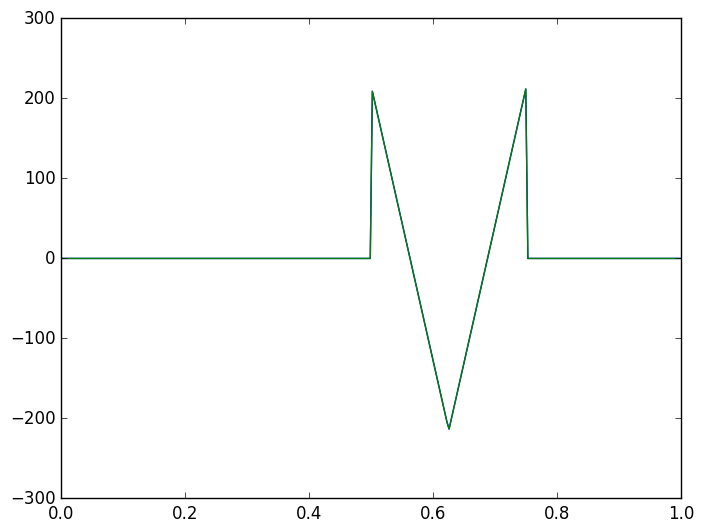

[vDv(3,2,2,i,3,3,3) for i = 1:3] = [-5.3290705182007514e-14,-41.079191812887586,-42.42640687119298]
[vDv(3,3,3,i,3,3,3) for i = 1:3] = [0.0,15.491933384829508,0.0]


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31fef1890>

In [74]:
@show [vDv(3,0,1,i,3,3,3) for i in 1:3]
@show [vDv(3,1,1,i,3,3,3) for i in 1:3]
@show [vDv(3,2,2,i,3,3,3) for i in 1:3]
@show [vDv(3,3,3,i,3,3,3) for i in 1:3]
plotfunc1D(x->dv(3,3,3,3,x[1]))
plotfunc1D(x->(15.491933384829702*v(3,3,3,2,x[1])+1.875*v(3,0,1,3,x[1])-41.079191812887586*v(3,2,2,2,x[1])-42.42640687119298*v(3,2,2,3,x[1])
                        -7.2618437741389315*v(3,1,1,2,x[1])+7.5*v(3,1,1,3,x[1])))
